In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch


Our functions

In [15]:
from Train_policy_func import Policy, load_policy
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_Scores
from OPPO import baseline_CartPole_v0_Fla, OPPO_update, set_seed
from PPO import evaluate_policy
from RLHF import RewardModel, train_reward_model,RewardModel_Acro
from pairs_generator import sample_preference_pairs, compute_reward_from_traj


In [4]:
class ShapedAcrobot(gym.Wrapper):
    def __init__(self, env, alpha=1.0, gamma=0.99):
        super().__init__(env)
        self.alpha, self.gamma = alpha, gamma
        self.last_pot = None

    def _potential(self, obs):
        c1, s1, c2, s2, a1, a2 = obs
        c12 = c1*c2 - s1*s2
        # normalized tip height in [–1,1]:
        return -(c1 + c12) / 2.0

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.last_pot = self._potential(obs)
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        # compute shaping term:
        pot = self._potential(obs)
        shaping = self.gamma * pot - self.last_pot
        shaped_reward = reward + self.alpha * shaping  #  -β*(θ̇1**2 + θ̇2**2)
        self.last_pot = pot
        return obs, shaped_reward, done, info

In [ ]:
# Parameters
env_name='Acrobot-v1-perso'
env = ShapedAcrobot(gym.make("Acrobot-v1"), alpha=1.0, gamma=0.99)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_policies=True
seed = np.random.choice([35, 42, 100])  # replace with your seed

try:
  if load_policies:
        print(fr"Loading pi_1 and pi_2 with {seed=}")
        pi_1 = load_policy(f"./Policies/pi1_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
except:
  # arbitrary choice to not generate the policies in this notebook
  print("pi_1 and pi_2 could not be loaded, please verify the files (we do not generate them in this script)")

Loading pi_1 and pi_2 with seed=35


### Somes tests for both good and bad policies:

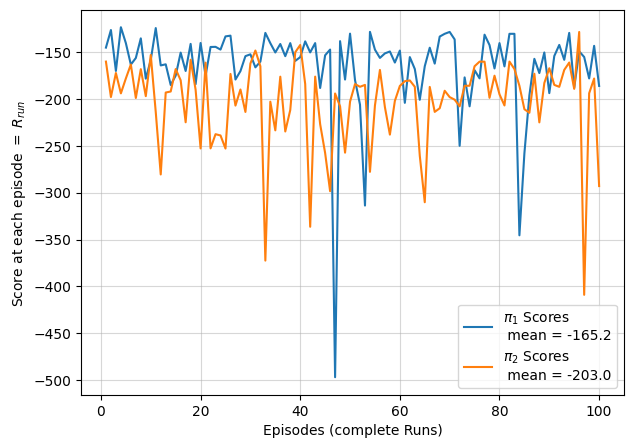

In [6]:

num_episodes = 100


pi1_mean_reward, pi1_rewards     = evaluate_policy(pi_1,     env, n_episodes=num_episodes)
pi2_mean_reward, pi_poor_rewards = evaluate_policy(pi_2,  env, n_episodes=num_episodes)

plot_Scores(
    pi1_rewards,
    pi_poor_rewards,
)

In [12]:
traj1 = generate_trajectory(pi_1,    env, max_steps=1000)
traj2 = generate_trajectory(pi_2, env, max_steps=1000)
print("on a test trajectory of maximum 1000 steps")
print(f"pi_1    → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")
print(f"pi_poor → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")

on a test trajectory of maximum 1000 steps
pi_1    → length 172, total reward -168.4
pi_poor → length 339, total reward -334.2


## Then create the RewardModel and train it

In [ ]:
# n_pairs = 300

for n_pairs in [20, 50, 200, 1000]:
  prefs   = sample_preference_pairs(pi_1, pi_2, env, K=n_pairs)
  print(f"Collected {n_pairs} preference pairs.")


  lr_reward     = 0.01

  reward_model  = RewardModel_Acro(state_dim=obs_dim, action_dim=action_dim).to(device)
  opt_reward    = torch.optim.Adam(reward_model.parameters(), lr=lr_reward)

  train_reward_model(reward_model, prefs, opt_reward, epochs=50)
  total_reward= compute_reward_from_traj(reward_model, traj1)

  # Test the reward model
  correct = 0
  for pair in prefs:
      r_pos = compute_reward_from_traj(reward_model, pair["traj_acc"])
      r_neg = compute_reward_from_traj(reward_model, pair["traj_rej"])
      if r_pos > r_neg:
          correct += 1
  accuracy = correct / len(prefs)
  print(f"Reward model with {n_pairs} pair ranking accuracy: {100*accuracy:.1f} %")

  torch.save(reward_model.state_dict(), f"./Policies/reward_model_{env_name}_Npairs_{n_pairs}.pth")


Collected 20 preference pairs.


Training Reward Model:   2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

Epoch 0: Reward model loss = 43.1656


Training Reward Model:  22%|██▏       | 11/50 [00:15<00:53,  1.38s/it]

Epoch 10: Reward model loss = 0.0024


Training Reward Model:  42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]

Epoch 20: Reward model loss = 0.0006


Training Reward Model:  62%|██████▏   | 31/50 [00:42<00:25,  1.36s/it]

Epoch 30: Reward model loss = 0.0004


Training Reward Model:  82%|████████▏ | 41/50 [00:56<00:12,  1.41s/it]

Epoch 40: Reward model loss = 0.0003


Reward model with 20 pair ranking accuracy: 100.0 %
Collected 50 preference pairs.


Training Reward Model:   2%|▏         | 1/50 [00:03<02:48,  3.43s/it]

Epoch 0: Reward model loss = 301.7156


Training Reward Model:  22%|██▏       | 11/50 [00:37<02:13,  3.42s/it]

Epoch 10: Reward model loss = 0.1084


Training Reward Model:  42%|████▏     | 21/50 [01:12<01:41,  3.50s/it]

Epoch 20: Reward model loss = 0.0288


Training Reward Model:  62%|██████▏   | 31/50 [01:48<01:08,  3.58s/it]

Epoch 30: Reward model loss = 0.0140


Training Reward Model:  82%|████████▏ | 41/50 [02:24<00:31,  3.55s/it]

Epoch 40: Reward model loss = 0.0081


Reward model with 50 pair ranking accuracy: 100.0 %
Collected 200 preference pairs.


Training Reward Model:   2%|▏         | 1/50 [00:15<12:21, 15.13s/it]

Epoch 0: Reward model loss = 155.9696


Training Reward Model:  22%|██▏       | 11/50 [02:40<09:14, 14.22s/it]

Epoch 10: Reward model loss = 0.5346


Training Reward Model:  42%|████▏     | 21/50 [05:01<06:49, 14.14s/it]

Epoch 20: Reward model loss = 0.0550


Training Reward Model:  62%|██████▏   | 31/50 [07:23<04:31, 14.30s/it]

Epoch 30: Reward model loss = 0.0148


Training Reward Model:  82%|████████▏ | 41/50 [09:40<02:03, 13.72s/it]

Epoch 40: Reward model loss = 0.0056


Reward model with 200 pair ranking accuracy: 100.0 %
